In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.optimize import fsolve
import scipy.optimize as opt
from scipy.optimize import root
import pandas as pd
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

def simulate_poisson_autoregression(n, d, a, b, y0, lambda0):
    Y = np.zeros(n)
    lambda_values = np.zeros(n)
    
    # Initial values
    Y[0] = y0
    lambda_values[0] = lambda0
    
    for t in range(1, n):
        lambda_values[t] = d + a * lambda_values[t - 1] + b * Y[t - 1]
        Y[t] = np.random.poisson(lambda_values[t])
    
    return Y, lambda_values

def log_likelihood(theta, Y, lambda0):
    n = len(Y)
    d, a, b = theta
    lambda_values = np.zeros(n)
    lambda_values[0] = lambda0  # initial value

    ll = 0
    for t in range(1, n):
        lambda_values[t] = d + a * lambda_values[t - 1] + b * Y[t - 1]
    
    ll = np.sum(Y * np.log(lambda_values) - lambda_values)
    if not np.isfinite(ll):
        return np.inf
    return -ll  

# Constraints
cons = (
    {'type': 'ineq', 'fun': lambda x: x[0]},  # d >= 0
    {'type': 'ineq', 'fun': lambda x: x[1]},  # a >= 0
    {'type': 'ineq', 'fun': lambda x: x[2]},  # b >= 0
    {'type': 'ineq', 'fun': lambda x: 1 - x[1] - x[2]}  # a + b < 1
)

In [5]:
# Function to run the MLE and collect results
def run_mle(Y, lambda0, theta0, true_params):
    start_time = time.time()
    result = minimize(log_likelihood, theta0, args=(Y, lambda0), constraints=cons, method='COBYLA')
    end_time = time.time()
    execution_time = end_time - start_time
    
    estimated_d, estimated_a, estimated_b = result.x
    accuracy_d = abs((estimated_d - true_params[0]) / true_params[0])
    accuracy_a = abs((estimated_a - true_params[1]) / true_params[1])
    accuracy_b = abs((estimated_b - true_params[2]) / true_params[2])
    
    return {
        'Initial guess': theta0,
        'Estimated d': estimated_d,
        'True d': true_params[0],
        'Accuracy d': accuracy_d,
        'Estimated a': estimated_a,
        'True a': true_params[1],
        'Accuracy a': accuracy_a,
        'Estimated b': estimated_b,
        'True b': true_params[2],
        'Accuracy b': accuracy_b,
        #'Log-likelihood': result.fun,
        'Execution time (s)': execution_time
    }

# Example parameter sets to test
parameter_sets = [
    (0.05, 0.063, 0.375),
    (0.1, 0.1, 0.3),
    (0.2, 0.2, 0.2),
    (0.05, 0.2, 0.1)
]

# Initial guesses for each run
initial_guesses = [
    [0.06, 0.06, 0.36],  # close to true values
    [0.1, 0.1, 0.1],  # a bit far from true values
    [0.5, 0.5, 0.5],  # far from true values
    [0.01, 0.01, 0.01],  # very far from true values
]

# Collect all results
results = []

# Loop through each parameter set
for true_d, true_a, true_b in parameter_sets:
    print(f"Testing with true parameters: d = {true_d}, a = {true_a}, b = {true_b}")
    
    # Simulate the data
    Y, lambda_values = simulate_poisson_autoregression(1000000, true_d, true_a, true_b, 1, 1.5)
    true_params = [true_d, true_a, true_b]
    
    # Test with multiple initial guesses
    for theta0 in initial_guesses:
        result = run_mle(Y, 1.5, theta0, true_params)
        results.append(result)

# Convert results to a DataFrame and display
df_results = pd.DataFrame(results)
print(df_results)

Testing with true parameters: d = 0.05, a = 0.063, b = 0.375


/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_1114/2494039999.py:34: RuntimeWarning: overflow encountered in double_scalars
  lambda_values[t] = d + a * lambda_values[t - 1] + b * Y[t - 1]
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_1114/2494039999.py:36: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(Y * np.log(lambda_values) - lambda_values)
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_1114/2494039999.py:36: RuntimeWarning: invalid value encountered in subtract
  ll = np.sum(Y * np.log(lambda_values) - lambda_values)
/Users/reaaaa/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Testing with true parameters: d = 0.1, a = 0.1, b = 0.3
Testing with true parameters: d = 0.2, a = 0.2, b = 0.2
Testing with true parameters: d = 0.05, a = 0.2, b = 0.1
         Initial guess  Estimated d  True d  Accuracy d  Estimated a  True a  \
0   [0.06, 0.06, 0.36]         0.06    0.05        0.20         0.06   0.063   
1      [0.1, 0.1, 0.1]         0.10    0.05        1.00         0.10   0.063   
2      [0.5, 0.5, 0.5]         0.50    0.05        9.00         0.50   0.063   
3   [0.01, 0.01, 0.01]         0.01    0.05        0.80         0.01   0.063   
4   [0.06, 0.06, 0.36]         0.06    0.10        0.40         0.06   0.100   
5      [0.1, 0.1, 0.1]         0.10    0.10        0.00         0.10   0.100   
6      [0.5, 0.5, 0.5]         0.50    0.10        4.00         0.50   0.100   
7   [0.01, 0.01, 0.01]         0.01    0.10        0.90         0.01   0.100   
8   [0.06, 0.06, 0.36]         0.06    0.20        0.70         0.06   0.200   
9      [0.1, 0.1, 0.1]         

In [73]:
def lambda_gradients(n, d, a, b, Y, lambda0):
    d_lambda_d = np.zeros(n)  
    d_lambda_a = np.zeros(n)
    d_lambda_b = np.zeros(n)
    lambda_t = np.zeros(n)
    
    lambda_t[0] = lambda0
    d_lambda_d[0] = 0
    d_lambda_a[0] = 0
    d_lambda_b[0] = 0

    for t in range(1, n):
        lambda_t[t] = d + a * lambda_t[t-1] + b * Y[t-1]
        d_lambda_d[t] = 1 + a * d_lambda_d[t-1]
        d_lambda_a[t] = lambda_t[t-1] + a * d_lambda_a[t-1]
        d_lambda_b[t] = Y[t-1] + a * d_lambda_b[t-1]

    return lambda_t, d_lambda_d, d_lambda_a, d_lambda_b

def score_function(params, Y, lambda0):
    d, a, b = params
    n = len(Y)
    lambda_t, d_lambda_d, d_lambda_a, d_lambda_b = lambda_gradients(n, d, a, b, Y, lambda0)
    score = np.zeros(3)

    for t in range(1, n):
        score[0] += (Y[t] / lambda_t[t] - 1) * d_lambda_d[t]
        score[1] += (Y[t] / lambda_t[t] - 1) * d_lambda_a[t]
        score[2] += (Y[t] / lambda_t[t] - 1) * d_lambda_b[t]

    return score

def run_mle_score_function(Y, lambda0, theta0, true_params):
    start_time = time.time()
    estimated_params = fsolve(score_function, theta0, args=(Y, lambda0))
    end_time = time.time()
    execution_time = end_time - start_time
    
    estimated_d, estimated_a, estimated_b = estimated_params
    accuracy_d = abs((estimated_d - true_params[0]) / true_params[0])
    accuracy_a = abs((estimated_a - true_params[1]) / true_params[1])
    accuracy_b = abs((estimated_b - true_params[2]) / true_params[2])
    
    return {
        'Initial guess': theta0,
        'Estimated d': estimated_d,
        'True d': true_params[0],
        'Accuracy d': accuracy_d,
        'Estimated a': estimated_a,
        'True a': true_params[1],
        'Accuracy a': accuracy_a,
        'Estimated b': estimated_b,
        'True b': true_params[2],
        'Accuracy b': accuracy_b,
        'Execution time (s)': execution_time
    }

parameter_sets = [
    (0.05, 0.063, 0.375),
    (0.1, 0.1, 0.3),
    (0.2, 0.2, 0.2),
    (0.05, 0.2, 0.1)
]

initial_guesses = [
    [0.06, 0.06, 0.36],  # close to true values
    [0.1, 0.1, 0.1],  # a bit far from true values
    [0.5, 0.5, 0.5],  # far from true values
    [0.01, 0.01, 0.01],  # very far from true values
]

results = []

for true_d, true_a, true_b in parameter_sets:
    print(f"Testing with true parameters: d = {true_d}, a = {true_a}, b = {true_b}")
    
    Y, lambda_values = simulate_poisson_autoregression(50000, true_d, true_a, true_b, 1, 1.5)
    true_params = [true_d, true_a, true_b]
    
    for theta0 in initial_guesses:
        result = run_mle_score_function(Y, 1.5, theta0, true_params)
        results.append(result)

df_results = pd.DataFrame(results)
print(df_results)

Testing with true parameters: d = 0.05, a = 0.063, b = 0.375


/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_41338/2991658790.py:15: RuntimeWarning: overflow encountered in double_scalars
  d_lambda_a[t] = lambda_t[t-1] + a * d_lambda_a[t-1]
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_41338/2991658790.py:16: RuntimeWarning: overflow encountered in double_scalars
  d_lambda_b[t] = Y[t-1] + a * d_lambda_b[t-1]
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_41338/2991658790.py:13: RuntimeWarning: overflow encountered in double_scalars
  lambda_t[t] = d + a * lambda_t[t-1] + b * Y[t-1]
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_41338/2991658790.py:14: RuntimeWarning: overflow encountered in double_scalars
  d_lambda_d[t] = 1 + a * d_lambda_d[t-1]
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_41338/2991658790.py:28: RuntimeWarning: invalid value encountered in double_scalars
  score[1] += (Y[t] / lambda_t[t] - 1) * d_lambda_a[t]
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykern

Testing with true parameters: d = 0.1, a = 0.1, b = 0.3


/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_41338/2991658790.py:28: RuntimeWarning: overflow encountered in double_scalars
  score[1] += (Y[t] / lambda_t[t] - 1) * d_lambda_a[t]
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_41338/2991658790.py:27: RuntimeWarning: overflow encountered in double_scalars
  score[0] += (Y[t] / lambda_t[t] - 1) * d_lambda_d[t]
/var/folders/6t/f2_zr7p57wv4z0jzmgwz_8dw0000gn/T/ipykernel_41338/2991658790.py:29: RuntimeWarning: overflow encountered in double_scalars
  score[2] += (Y[t] / lambda_t[t] - 1) * d_lambda_b[t]


Testing with true parameters: d = 0.2, a = 0.2, b = 0.2
Testing with true parameters: d = 0.05, a = 0.2, b = 0.1
         Initial guess  Estimated d  True d  Accuracy d  Estimated a  True a  \
0   [0.06, 0.06, 0.36]     0.048867    0.05    0.022656     0.074003   0.063   
1      [0.1, 0.1, 0.1]     0.100000    0.05    1.000000     0.100000   0.063   
2      [0.5, 0.5, 0.5]     0.120202    0.05    1.404047    -0.742932   0.063   
3   [0.01, 0.01, 0.01]     0.010000    0.05    0.800000     0.010000   0.063   
4   [0.06, 0.06, 0.36]     0.097416    0.10    0.025842     0.116320   0.100   
5      [0.1, 0.1, 0.1]     0.100000    0.10    0.000000     0.100000   0.100   
6      [0.5, 0.5, 0.5]     0.097416    0.10    0.025842     0.116320   0.100   
7   [0.01, 0.01, 0.01]     0.010000    0.10    0.900000     0.010000   0.100   
8   [0.06, 0.06, 0.36]     0.196014    0.20    0.019929     0.208823   0.200   
9      [0.1, 0.1, 0.1]     0.100000    0.20    0.500000     0.100000   0.200   
10     

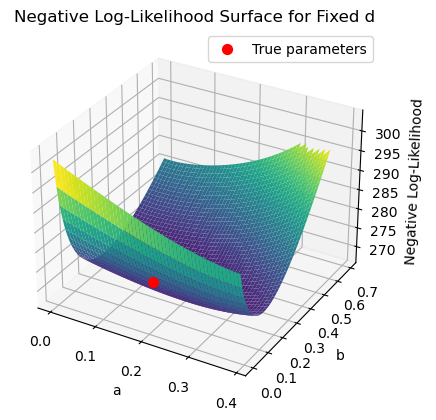

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def simulate_poisson_autoregression(n, d, a, b, y0, lambda0):
    Y = np.zeros(n)
    lambda_values = np.zeros(n)
    
    # Initial values
    Y[0] = y0
    lambda_values[0] = lambda0
    
    for t in range(1, n):
        lambda_values[t] = d + a * lambda_values[t - 1] + b * Y[t - 1]
        Y[t] = np.random.poisson(lambda_values[t])
    
    return Y, lambda_values

def log_likelihood(theta, Y, lambda0):
    n = len(Y)
    d, a, b = theta
    lambda_values = np.zeros(n)
    lambda_values[0] = lambda0  # initial value

    ll = 0
    for t in range(1, n):
        lambda_values[t] = d + a * lambda_values[t - 1] + b * Y[t - 1]
    
    ll = np.sum(Y * np.log(lambda_values) - lambda_values)
    if not np.isfinite(ll):
        return np.inf
    return -ll  

# Constraints
cons = (
    {'type': 'ineq', 'fun': lambda x: x[0]},  # d >= 0
    {'type': 'ineq', 'fun': lambda x: x[1]},  # a >= 0
    {'type': 'ineq', 'fun': lambda x: x[2]},  # b >= 0
    {'type': 'ineq', 'fun': lambda x: 1 - x[1] - x[2]}  # a + b < 1
)

# Simulate initial data
n = 1000
y0 = 1
lambda0 = 1.5
a1 = 0.13
b1 = 0.23
fixed_d = 0.05

a_values = np.linspace(0, 3*a1, 300)
b_values = np.linspace(0, 3*b1, 300)
A, B = np.meshgrid(a_values, b_values)
LL = np.zeros_like(A)

Y, _ = simulate_poisson_autoregression(n, fixed_d, a1, b1, y0, lambda0)

# Calculate log-likelihood for each pair of (a, b)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i, j] + B[i, j] < 1:
            theta = [fixed_d, A[i, j], B[i, j]]
            LL[i, j] = log_likelihood(theta, Y, lambda0)
        else:
            LL[i, j] = np.inf  # To handle the constraint

# Plot 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, LL, cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Negative Log-Likelihood')
plt.title('Negative Log-Likelihood Surface for Fixed d')

# Add a point for the true parameter values
ax.scatter(a1, b1, log_likelihood([fixed_d, a1, b1], Y, lambda0), color='r', s=50, label='True parameters')

plt.legend()
plt.show()